In [1]:
# import libraries
import pandas as pd
import scipy.stats
import statsmodels.stats.multitest
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# disable warnings, use w caution
import warnings
warnings.filterwarnings('ignore')

# project specific libs
import os
import matplotlib.pyplot as plt

In [2]:
# set (local) path
path = '/Users/KevinBu/Desktop/clemente_lab/Projects/ampaim/'

In [3]:
###
# Load AB mapping file
###

# get AMPAIM+EISER mapping file w metadata; drop row 1
df_map_AB = pd.read_csv(path + 'inputs/adamcantor22_Cross_Disease_Pilot_0/Qiime2_0/qiime_mapping_file.tsv', sep='\t', header=0, index_col=0)

# get first row for any future operations
first_row = df_map_AB.reset_index().iloc[0,]
first_row_df = pd.DataFrame(first_row).T
df_map_AB = df_map_AB.iloc[1:,]


###
# Specific replacements
###

# 526-0-twin-psaplate308 is missing a dash
df_map_AB = df_map_AB.rename(index={'526-0-twin-psaplate308': '526-0-twin-psa-plate308'})

###
# General replacements
###

# refrain from dropping NA's because you might need the columns for Q2 and you need to smoothly concat the first row

# convert index to str from float etc.
df_map_AB.index = df_map_AB.index.map(str)

# switch EISER diagnosis to eiser from NA
df_map_AB.loc[df_map_AB['Project'] == 'eiser', 'Diagnosis'] = 'eiser'

# RBB mapping file doesn't have info on duplicate controls, and the glass control info is extracted only from a subset of the names
# so we need to grab that info from AB's mapping file
samp_to_ctrlstatus = df_map_AB['Project'].to_dict()

# grab AB non-microteach samples
df_map_AB_filt = df_map_AB[df_map_AB['Project'].isin(['eiser','TWIN_PSA','glass_control','neg_control','duplicate_control'])]

df_map_AB_filt.head()

,BarcodeSequence,LinkerPrimerSequence,AmpliconWell,BSA,BSASeverityByBSA,CCPtiter,CRP,CurrentBiologics,CurrentIntralesionalSteroids,CurrentMTX,...,StudyType,SubjectType,BirthYear,HostSubjectId,Nationality,Sex,SpecimenType,UberonCodeType,Weight,WeightDateCollected
#SampleID,,,,,,,,,,,,,,,,,,,,,
116783-plate305,CCTCGCATGACC,CCGGACTACHVGGGTWTCTAAT,A1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Human,NaN,116783,NaN,NaN,fecal,NaN,NaN,NaN
116784-plate305,CGCGCAAGTATT,CCGGACTACHVGGGTWTCTAAT,B1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Human,NaN,116784,NaN,NaN,fecal,NaN,NaN,NaN
116785-plate305,AAGGCGCTCCTT,CCGGACTACHVGGGTWTCTAAT,C1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Human,NaN,116785,NaN,NaN,fecal,NaN,NaN,NaN
116786-plate305,CGCAATGAGGGA,CCGGACTACHVGGGTWTCTAAT,D1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Human,NaN,116786,NaN,NaN,fecal,NaN,NaN,NaN
116787-plate305,ACGGCGTTATGT,CCGGACTACHVGGGTWTCTAAT,E1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Human,NaN,116787,NaN,NaN,fecal,NaN,NaN,NaN


In [4]:
###
# Prepare for merge with RB mapping file
###

# load RB mapping file
df_map_RB = pd.read_csv(path + 'inputs/qiime_mapping_file_final_062123_RBB_ESR_CRPmod.csv', index_col=0)

# skip row with q2types; 140 columns
df_map_RB = df_map_RB.iloc[1:,]

# exclude unaffected since we are using TWINS_PSA from AB and controls from AB
# we only want microteach samples
df_map_RB = df_map_RB[df_map_RB['Diagnosis'].isin(['healthy','ss','sle','cd','RA','psa','pso'])]

# drop duplicate samples that appear in AB and that are controls per AB mapping file
for s in list(df_map_RB.index.values):
    if samp_to_ctrlstatus[s] in ['glass_control','duplicate_control','neg_control']:
        df_map_RB = df_map_RB.drop(s)
        
        
# merge with AB
df_meta = pd.concat([df_map_AB_filt, df_map_RB], axis=0)

# drop 'Separate' and 'Together'; presumably Q2 artifacts
df_meta = df_meta.drop(['Separate','Together'], axis=1)

# add in Project col from AB that describes controls
df_meta['Project'] = df_meta.index.map(samp_to_ctrlstatus)

###
# Specific replacements
###

# replace HxOtherDMARDs
df_meta.loc['540-0-twin-psa-plate308','HxOtherDMARDs'] = 'N'

### 
# General replacements
###

# specify float cols for later
float_cols = ['Age','BSA','CRP','DAS28','ESR','PhysicianGlobalPsA','RAPID3','SJC','TJC']

# Replace Y,N with 1,0 
df_meta = df_meta.replace({'Y':1,'N':0})

# create dict mapping diagnosis to samples
diag_to_samp = {}
for d in list(set(df_meta['Diagnosis'].values)):
    diag_to_samp[d] = list(df_meta[df_meta['Diagnosis'] == d].index.values)

### 
# Create new mapping files
### 

def export_q2(df, first_row_df):
    df_q2 = df.reset_index()
    df_q2 = pd.concat([first_row_df, df_q2])
    df_q2 = df_q2.set_index('#SampleID')
    df_q2.loc['#q2:types',:] = 'categorical'
    df_q2 = df_q2.reset_index()
    return df_q2

# (1) filter out controls
df_meta = df_meta[df_meta['Project'].isin(['eiser','microteach','TWIN_PSA'])]

# (2) filter out treatments
# drop TWIN PSA and PSO samples that have treatment on biologics, DMARDS, MTX
drop_samples = ['275-psa-plate307', '475-psa-plate307', '542-0-twin-psa-plate308']
df_meta = df_meta.drop(drop_samples)

# remove samples that are treated other than above
drops = []
for v in ['CurrentBiologics', 'CurrentOtherDMARDs', 'CurrentMTX', 'HxOtherDMARDs']:
    df = df_meta[df_meta[v].isin(['Y',1])]
    drops = drops + list(df.index.values)

df_meta = df_meta.drop(drops)
print('Dropped this many samples: ' + str(len(drops)))

# drop eiser samples from downstream analysis
df_meta = df_meta[df_meta['Diagnosis'] != 'eiser']

# keep only psa
df_meta = df_meta[df_meta['Diagnosis'] == 'psa']

# export to Q2
df_meta_q2 = export_q2(df_meta, first_row_df)
df_meta_q2.to_csv(path + 'inputs/qiime_mapping_file_noctrl_noeiser_psaonly.tsv', sep='\t', index=False, na_rep='nan') 

###
# Pre-processing
###

df_meta['Diagnosis'].value_counts()

Dropped this many samples: 18


Diagnosis
psa    27
Name: count, dtype: int64

In [13]:
# merge CDP and MSQ141 MMEDs qiime mapping files
# load CDP
df_cdp = pd.read_csv(path + 'inputs/qiime_mapping_file_noctrl_noeiser_psaonly.tsv', sep='\t')
df_cdp['Batch'] = 'CDP'

# load MSQ141
df_141 = pd.read_csv(path + 'inputs/qiime_mapping_file_MSQ141.tsv', sep='\t')

# drop row 0 (#q2types) prior to merge
df_141 = df_141.iloc[1:,:]
df_141['Batch'] = 'MSQ141'

# add in diagnosis column that is IllnessNotes to all lowercase
df_141['Diagnosis'] = df_141['IllnessNotes'].apply(lambda x: x.lower())

# replace sjd with ss and psa_pso with psa
df_141['Diagnosis'] = df_141['Diagnosis'].replace('sjd','ss')
df_141['Diagnosis'] = df_141['Diagnosis'].replace('psa_pso','psa')
df_141['Diagnosis'] = df_141['Diagnosis'].replace('ra','RA')

# merge rows
df_merge = pd.concat([df_cdp, df_141])#, axis=1)
df_merge = df_merge.set_index('#SampleID')
df_merge.loc['#q2:types',:] = 'categorical'

# note that lots of reasons might exist for batch effect, like treatment, also different diseases
# columns are not consistent (e.g. IllnessNotes in MSQ141 vs Diagnosis in CDP)
df_merge.to_csv(path + 'inputs/qiime_mapping_file_batch_nocd.tsv', sep='\t')

# standard binarize column for each medication
# convert from float
df_merge['Medication'] = df_merge['Medication'].astype(str)

# grab all medications
meds = list(df_merge['Medication'].values)

# drop 'categorical'
meds.remove('categorical')

uniq_meds = []
# split items with '_'
for m in meds:
    if '_' in m:
        items = m.split('_')
        items = [i.lower() for i in items]
        uniq_meds = uniq_meds + items
    else:
        uniq_meds.append(m.lower())
    
uniq_meds = list(set(list(uniq_meds)))
print(uniq_meds)

# create new column for each med
for u in uniq_meds:
    df_merge[u] = 0
    df_merge.loc[0,u] = 'categorical'

# iterate through each sample
for index, row in df_merge.iterrows():
    if index != 0: # the whole '#q2:types', 'categorical' thing
        medications = df_merge.loc[index,'Medication'].lower()
        medications = medications.split('_')
        for m in medications:    
            df_merge.loc[index,m] = 1

# new mapping file with med columns
df_merge = df_merge[df_merge['Diagnosis'] == 'psa']

# keep only those with psa data
df_merge = df_merge.dropna(subset='PsAtype')# [df_merge['PsAtype']


# create a new column 'Involvement' that is 'Axial' if PsAtype is 'peripheral_axial', 'axial', or 'Spine involvement'
# print(df_merge['PsAtype'].value_counts())
df_merge['Involvement'] = df_merge['PsAtype'].apply(lambda x: 'peripheral' if x == 'peripheral' else 'axial')
# print(df_merge['Involvement'].value_counts()) 19 periph to 8 axial

df_merge_q2 = export_q2(df_merge, first_row_df)
df_merge_q2.to_csv(path + 'inputs/qiime_mapping_file_merge_meds_psaonly.tsv', sep='\t', index=False, na_rep='nan') 

df_merge.head()

['mtx', 'nan', 'nomed', 'topicals', 'prednisone', 'hcq', 'leflunomide']
Involvement
peripheral    19
axial          8
Name: count, dtype: int64


,BarcodeSequence,LinkerPrimerSequence,AmpliconWell,BSA,BSASeverityByBSA,CCPtiter,CRP,CurrentBiologics,CurrentIntralesionalSteroids,CurrentMTX,...,AgeAtVisit,mtx,nan,nomed,topicals,prednisone,hcq,leflunomide,categorical,Involvement
#SampleID,,,,,,,,,,,,,,,,,,,,,
530-0-twin-psa-plate308,TATGCCAGAGAT,CCGGACTACHVGGGTWTCTAAT,C4,0.5,NaN,NaN,NaN,0.0,NaN,0.0,...,NaN,0.0,1,0,0,0,0,0,NaN,axial
235-psa-plate307,TGCGCGCCTTCC,CCGGACTACHVGGGTWTCTAAT,E3,3,mild,NaN,NaN,0.0,0.0,0.0,...,NaN,0.0,1,0,0,0,0,0,NaN,peripheral
240-psa-plate307,GCGCACACCTTC,CCGGACTACHVGGGTWTCTAAT,F3,13,severe,NaN,NaN,0.0,0.0,NaN,...,NaN,0.0,1,0,0,0,0,0,NaN,axial
272-psa-plate307,CACGAAAGCAGG,CCGGACTACHVGGGTWTCTAAT,G3,NaN,NaN,NaN,0.3,0.0,0.0,0.0,...,NaN,0.0,1,0,0,0,0,0,NaN,axial
288-psa-plate307,ATTTGGCTCTTA,CCGGACTACHVGGGTWTCTAAT,A4,7,moderate,NaN,NaN,0.0,0.0,NaN,...,NaN,0.0,1,0,0,0,0,0,NaN,axial


In [ ]:
# EVERYTHING BELOW HERE HASN"T BEEN TOUCHED

In [14]:
# unnormalized OTU table level-6 also has metadata in it! nice 
# from taxa_bar_plot.qzv
#df_otu = pd.read_csv(path + 'inputs/Qiime2_0_KB_noctrl_noeiser_nocd/level-5.csv', index_col=0)
#df_otu = pd.read_csv(path + 'inputs/Qiime2_0_KB_batch_nocd_full/level-5.csv', index_col=0)
#df_otu = pd.read_csv(path + 'inputs/Qiime2_0_KB_noctrl_noeiser_nocd/level-6.csv', index_col=0)
# df_otu = pd.read_csv(path + 'inputs/Qiime2_0_KB_batch_correct_nocd/level-6.csv', index_col=0)
#df_otu = pd.read_csv(path + 'inputs/Qiime2_0_KB_noctrl_noeiser_nocd/level-7.csv', index_col=0)
df_otu = pd.read_csv(path + 'inputs/Qiime2_0_KB_batch_nocd_full/level-7.csv', index_col=0)

# determine columns to drop; i.e. keep taxa only
dropcol = []
for c in list(df_otu.columns.values):
    if c[0:3] != 'k__':
        dropcol.append(c)
        
# keep Diagnosis for later
keepcol = df_otu['Diagnosis']

df_otu = df_otu.drop(dropcol, axis=1)
# df_otu.to_csv(path + 'inputs/Qiime2_0_KB_batch_correct_nocd/counts_L6.csv')

# normalize the cols
df_otu = df_otu.div(df_otu.sum(axis=1), axis=0)
# df_otu.to_csv(path + 'inputs/Qiime2_0_KB_batch_correct_nocd/otu_table_L6.csv')

# reappend dx
df_otu = pd.concat([df_otu, keepcol],axis=1)
df_otu.head()

,k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobrevibacter;s__,k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanosphaera;s__,k__Archaea;p__Euryarchaeota;c__Thermoplasmata;o__E2;f__[Methanomassiliicoccaceae];g__vadinCA11;s__,k__Bacteria;__;__;__;__;__;__,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__;s__,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Varibaculum;s__,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Corynebacteriaceae;g__Corynebacterium;__,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Corynebacteriaceae;g__Corynebacterium;s__,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Corynebacteriaceae;g__Corynebacterium;s__durum,...,k__Bacteria;p__Synergistetes;c__Synergistia;o__Synergistales;f__Synergistaceae;g__Synergistes;s__,k__Bacteria;p__TM7;c__TM7-3;o__;f__;g__;s__,k__Bacteria;p__TM7;c__TM7-3;o__CW040;f__;g__;s__,k__Bacteria;p__TM7;c__TM7-3;o__I025;f__Rs-045;g__;s__,k__Bacteria;p__Tenericutes;c__Mollicutes;o__RF39;f__;g__;s__,k__Bacteria;p__Tenericutes;c__RF3;o__ML615J-28;f__;g__;s__,k__Bacteria;p__Verrucomicrobia;c__Opitutae;o__[Cerasicoccales];f__[Cerasicoccaceae];g__;s__,k__Bacteria;p__Verrucomicrobia;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Verrucomicrobiaceae;__;__,k__Bacteria;p__Verrucomicrobia;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Verrucomicrobiaceae;g__Akkermansia;s__muciniphila,Diagnosis
index,,,,,,,,,,,,,,,,,,,,,
131-slesjo-plate308,0.00000,0.0,0.0,0.000182,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.076520,ss
209-pso-plate307,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,pso
235-psa-plate307,0.00000,0.0,0.0,0.000000,0.0,0.000452,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.240123,psa
240-psa-plate307,0.00000,0.0,0.0,0.000000,0.0,0.000384,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.083634,psa
241-pso-plate307,0.29776,0.0,0.0,0.000000,0.0,0.001323,0.000183,0.0,0.0,0.0,...,0.0,0.000091,0.0,0.0,0.025232,0.0,0.0,0.0,0.000000,pso


KruskalResult(statistic=0.029510677652614725, pvalue=0.8636052051129975)


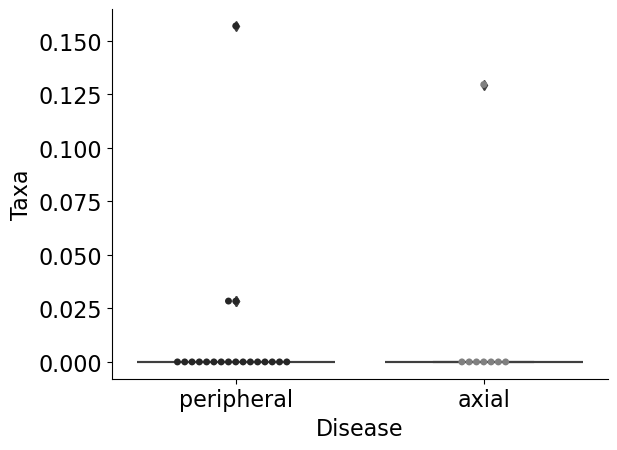

In [19]:
# taxa of interest
pcopri = 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__copri'
#pcopri = 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Rikenellaceae'
#pcopri = 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Veillonellaceae;g__Phascolarctobacterium'
# pcopri = 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Oxalobacteraceae'
# pcopri = 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Oxalobacteraceae;g__Oxalobacter'
# pcopri ='k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__luteciae'

# psa only
df_otu_spec = pd.concat([df_otu,df_merge['Involvement']],axis=1)
#df_otu_spec = df_otu[df_otu['Diagnosis'].isin(['RA','healthy'])]
df_otu_spec = df_otu_spec[df_otu_spec['Involvement'].isin(['axial','peripheral'])]

# KW test
print(scipy.stats.kruskal(*list(df_otu_spec.groupby('Involvement')[pcopri].apply(list).values), nan_policy='propagate', axis=0, keepdims=False))

# do sns 
ax = sns.boxplot(data=df_otu_spec, x='Involvement', y=pcopri)
sns.swarmplot(data=df_otu_spec, x='Involvement', y=pcopri, palette='dark:grey', hue=None)

# ax.axes.set_title("Title",fontsize=48)
#ax.set_ylabel("Rikenellaceae",fontsize=16)
#ax.set_ylabel("Phascolarctobacterium",fontsize=16)
ax.set_ylabel("Taxa",fontsize=16)
#ax.set_ylabel("P. copri",fontsize=16)
ax.set_xlabel("Disease",fontsize=16)
ax.tick_params(labelsize=16)

sns.despine()
# sns.boxplot([RA_pc, H_pc])

In [139]:
for x in list(df_otu_spec.columns.values):
    if 'lute' in x: #Oxalo
        print(x)
    
df_otu_spec[pcopri].value_counts()


k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__luteciae


k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__luteciae
0.000000    101
0.005607      1
0.282243      1
0.004148      1
Name: count, dtype: int64

In [ ]:
# PICRUST2
# don't forget to uncompress path_abun_unstrat.tsv.gz
# 393 columns/pathways represented here
df_fxn = pd.read_csv(path + 'inputs/adamcantor22_Cross_Disease_Pilot_0/PiCRUSt2_0/picrust2_out/pathways_out/path_abun_unstrat.tsv', sep='\t', index_col=0).T
KO_names = list(df_fxn.columns.values)

# normalize by row total (per sample basis)
df_fxn = df_fxn.div(df_fxn.sum(axis=1), axis=0)
df_fxn.to_csv(path + 'inputs/df_pathways.tsv', sep='\t')

# new metadata for concatenation
# df_meta_sample = df_meta.set_index('SampleID')

# concatenate
# df_pi = pd.concat([df_meta_sample, df_fxn], axis=1)
# df_pi.head()

#gene names; KO is just a placeholder
# KO_names = [x for x in df_pi.columns.values if x[0] == 'K']
# KO_names = [x for x in df_pi.columns.values if x[-3:] == 'PWY']

# RA first
# df_KO = df_pi[df_pi['Diagnosis'].isin(['healthy','RA'])]#'pso','psa'])]
# df_KO = df_KO[KO_names + ['Diagnosis']]

# subset
# df_ra_KO = df_KO[df_KO['Diagnosis'].isin(['RA'])]#'pso','psa'])]
# df_healthy_KO = df_KO[df_KO['Diagnosis'].isin(['healthy'])]


df_fxn.head()

In [ ]:
# get filtered meta for float cols only
df_meta_filt = df_meta[float_cols]

# merge OTU and df_meta
df_complete = pd.concat([df_otu, df_meta_filt, df_fxn], axis=1)
df_complete.head()

In [ ]:
# aggregate disease vs healthy analysis first
diag_healthy = ['healthy'] #['unaffected','healthy']
diag_disease = ['RA', 'psa', 'pso', 'ss', 'cd', 'sle']

# 
samp_healthy, samp_disease = [], []
for d in diag_healthy:
    samp_healthy = samp_healthy + diag_to_samp[d]
for d in diag_disease:
    samp_disease = samp_disease + diag_to_samp[d]
    
df_complete_healthy = df_complete.loc[samp_healthy]
df_complete_disease = df_complete.loc[samp_disease]

# save with index_label to avoid CUTIE errors
df_complete_healthy.to_csv(path + 'inputs/df_complete_healthy.tsv', sep='\t', index_label='Samples')
df_complete_disease.to_csv(path + 'inputs/df_complete_disease.tsv', sep='\t', index_label='Samples')

df_complete_healthy


#df_meta['Diagnosis'].value_counts()
#df_disease = df_complete[df_complete['Diagnosis']]
# samp_disease


In [ ]:
# plotting differential picrust metacyc pathways
pvals = []
tvals = []
KO = KO_names#[0:1000]

# get OG p values
for k in KO:
    x = df_complete_healthy[k].values
    y = df_complete_disease[k].values
    t, p = scipy.stats.ttest_ind(x,y)
    # remove nans or else, but this might not be the best way
    # https://github.com/statsmodels/statsmodels/issues/2899
    if np.isnan(p):
        pvals.append(1)
    else:
        pvals.append(p)
        tvals.append(t)


# https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.fdrcorrection.html
qvals = statsmodels.stats.multitest.fdrcorrection(np.array(pvals), alpha=0.05, method='indep', is_sorted=False)[1]        
# one day the scipy library will have it (1.11, the next release apparently as of 8/29/2023)
# scipy.stats.false_discovery_control(ps)

df_complete_nonfilt = pd.concat([df_otu, df_meta, df_fxn], axis=1)

try:
    os.mkdir(path + 'outputs/metacycp/')
except:
    pass

try:
    os.mkdir(path + 'outputs/metacycq/')
except:
    pass


# convert to q values
sig_list = []
for i in range(len(KO)):
    p, q = pvals[i], qvals[i]
    k = KO[i]      
    if p < 0.05:        
        sig_list.append(k)
        print(k)
        print(tvals[i], pvals[i])
        sns.set(style="darkgrid")
        plt.subplots(figsize=(6, 4))
        plt.tight_layout()
        ax = sns.boxplot(data=df_complete_nonfilt, x='Diagnosis', y=k)

        # save the plot as PNG file
        plt.savefig(path + 'outputs/metacycp/' + k + '.png',  bbox_inches="tight")
        if q < 0.05:
            plt.savefig(path + 'outputs/metacycq/' + k + '.png',  bbox_inches="tight")
            
        plt.close()
                        
            
print(len(sig_list))



In [ ]:
# combine LEfSe results
# all files are lefse_table.tsv
'''
outputs/
	jobs02							# LEfSe for PsAvH
	jobs03							# LEfSe for PsOvH
graphs/
    LEfSe_3                         # AvH
    LEfSe_4                         # RAvH
    LEfSe_5                         # PsA+PsO aka PSvH
    LEfSe_6                         # SSvH
    LEfSe_7                         # SLEvH
    LEfSe_8                         # CDvH
    LEfSe_9                         # SS+SLE aka SSSLEvH
    LEfSe_10                        # RA+PsA aka RAPsAvH
'''
# create dict mapping diagnosis to lefse results
# start w/ two disease for play testing
# eventually can consider the enriched in H set, but start with enriched in diseased set
diag_to_lefse_disease = {
    'PsA': [],
    'PsO': [],
    'PS': [],
    'A': [],
    'RA': [],
    'SS': [],
    'SLE': [],
    'SSSLE': [],
    'CD': [],
    'RAPsA': []
}

diag_to_path ={
    'PsA': 'outputs/jobs02/',
    'PsO': 'outputs/jobs03/',
    'PS': 'graphs/LEfSe_5/',
    'A': 'graphs/LEfSe_3/',
    'RA': 'graphs/LEfSe_4/',
    'SS': 'graphs/LEfSe_6/',
    'SLE': 'graphs/LEfSe_7/',
    'CD': 'graphs/LEfSe_8/',
    'SSSLE': 'graphs/LEfSe_9/',
    'RAPsA': 'graphs/LEfSe_10/',
}

for diag in diag_to_path:
    # import df, rename columns
    df_lefse = pd.read_csv(path + diag_to_path[diag] + 'lefse_results.res', sep='\t', header=None)    
    df_lefse.columns = ['Taxa','Effect_Size', 'Enriched_Group', 'Test_statistic','P_value']
    
    # replace dash with nan, cast to float
    df_lefse = df_lefse.replace('-', np.nan)
    df_lefse['P_value'] = df_lefse['P_value'].astype(float) 
    
    # get sig results and results pertaining to enriched group
    df_lefse = df_lefse[df_lefse['P_value'] <= 0.05]
    df_lefse = df_lefse[df_lefse['Enriched_Group'] != 'healthy']
    
    # drop na
    df_lefse = df_lefse.dropna()
    
    print(diag)
    print(len(df_lefse))
    #df_lefse = df_lefse.sort_values('Effect_Size')
    df_lefse.to_csv(path + 'outputs/jobs04/' + diag + '_lefse_sig.tsv', sep='\t')
    diag_to_lefse_disease[diag] = list(df_lefse['Taxa'].values)

# convert to df for output file to R
# summary_df = pd.Dataframe()
# summary_df = pd.DataFrame.from_dict(diag_to_lefse)
# summary_df




In [ ]:
# input query as list of sets
query = []
# query = ['SLE','SSSLE','RA','RAPsA','SS','PsO','PsA','PS','A']
query = ['PS','A']
query = ['RA','RAPsA']

# compute intersection 
result = set.intersection(*[set(diag_to_lefse_disease[q]) for q in query])
print(len(result))
print(result)


In [ ]:
# combine LEfSe results
# all files are lefse_table.tsv
'''
outputs/
	jobs02							# LEfSe for PsAvH
	jobs03							# LEfSe for PsOvH
graphs/
    LEfSe_3                         # AvH
    LEfSe_4                         # RAvH
    LEfSe_5                         # PsA+PsO aka PSvH
    LEfSe_6                         # SSvH
    LEfSe_7                         # SLEvH
    LEfSe_8                         # CDvH
    LEfSe_9                         # SS+SLE aka SSSLEvH
    LEfSe_10                        # RA+PsA aka RAPsAvH
'''
# create dict mapping diagnosis to lefse results
# start w/ two disease for play testing
# eventually can consider the enriched in H set, but start with enriched in diseased set
diag_to_lefse_healthy = {
    'PsA': [],
    'PsO': [],
    'PS': [],
    'A': [],
    'RA': [],
    'SS': [],
    'SLE': [],
    'SSSLE': [],
    'CD': [],
    'RAPsA': []
}

diag_to_path ={
    'PsA': 'outputs/jobs02/',
    'PsO': 'outputs/jobs03/',
    'PS': 'graphs/LEfSe_5/',
    'A': 'graphs/LEfSe_3/',
    'RA': 'graphs/LEfSe_4/',
    'SS': 'graphs/LEfSe_6/',
    'SLE': 'graphs/LEfSe_7/',
    'CD': 'graphs/LEfSe_8/',
    'SSSLE': 'graphs/LEfSe_9/',
    'RAPsA': 'graphs/LEfSe_10/',
}

for diag in diag_to_path:
    # import df, rename columns
    df_lefse = pd.read_csv(path + diag_to_path[diag] + 'lefse_results.res', sep='\t', header=None)    
    df_lefse.columns = ['Taxa','Effect_Size', 'Enriched_Group', 'Test_statistic','P_value']
    
    # replace dash with nan, cast to float
    df_lefse = df_lefse.replace('-', np.nan)
    df_lefse['P_value'] = df_lefse['P_value'].astype(float) 
    
    # get sig results and results pertaining to enriched group
    df_lefse = df_lefse[df_lefse['P_value'] <= 0.05]
    df_lefse = df_lefse[df_lefse['Enriched_Group'] == 'healthy']
    
    # drop na
    df_lefse = df_lefse.dropna()
    
    print(diag)
    print(len(df_lefse))
    #df_lefse = df_lefse.sort_values('Effect_Size')
    df_lefse.to_csv(path + 'outputs/jobs04/' + diag + '_lefse_healthy_sig.tsv', sep='\t')
    diag_to_lefse_healthy[diag] = list(df_lefse['Taxa'].values)

# convert to df for output file to R
# summary_df = pd.Dataframe()
# summary_df = pd.DataFrame.from_dict(diag_to_lefse)
# summary_df




In [ ]:
# input query as list of sets
query = []
query = ['SLE','SSSLE','RA','RAPsA','SS','PsO','PsA','PS','A']
query = ['SLE','RA','SS','PsO','PsA']

# compute intersection 
result = set.intersection(*[set(diag_to_lefse_healthy[q]) for q in query])
print(len(result))
print(result)
